In [ ]:
!pip install liac-arff

In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import hamming_loss, coverage_error, label_ranking_average_precision_score, label_ranking_loss
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import arff

In [31]:

def load_arff_to_df(file_path):
    with open(file_path) as f:
        arff_data = arff.load(f)
    df = pd.DataFrame(arff_data['data'], columns=[attr[0] for attr in arff_data['attributes']])
    return df


In [32]:
def prepare_datasets(dataset_type, train_file_path=None, test_file_path=None, data_file_path=None, test_size=0.2, random_state=42):
    if dataset_type == 'split':
        if train_file_path is None or test_file_path is None:
            raise ValueError("For 'split' type, train_file_path and test_file_path must be provided.")
        train_df = load_arff_to_df(train_file_path)
        test_df = load_arff_to_df(test_file_path)
    elif dataset_type == 'combined':
        if data_file_path is None:
            raise ValueError("For 'combined' type, data_file_path must be provided.")
        df = load_arff_to_df(data_file_path)
        train_df, test_df = train_test_split(df, test_size=test_size, random_state=random_state)
    else:
        raise ValueError("dataset_type must be either 'split' or 'combined'.")
    return train_df, test_df

In [53]:
def separate_features_and_labels(dataset_type, train_file_path=None, test_file_path=None, data_file_path=None, test_size=0.2, random_state=42):
    train_df, test_df = prepare_datasets(
        dataset_type=dataset_type,
        train_file_path=train_file_path,
        test_file_path=test_file_path,
        data_file_path=data_file_path,
        test_size=test_size,
        random_state=random_state
    )
    class_columns_train = [col for col in train_df.columns if '.' in col or col.startswith('Class-')]
    feature_columns_train = [col for col in train_df.columns if  '.' not in col or col.startswith('Class-')]
    
    class_columns_test = [col for col in test_df.columns if '.' in col or col.startswith('Class-')]
    feature_columns_test = [col for col in test_df.columns if  '.' not in col or col.startswith('Class-')]
    
    X_train = train_df[feature_columns_train]
    y_train = train_df[class_columns_train]
    
    X_test = test_df[feature_columns_test]
    y_test = test_df[class_columns_test]
    
    return X_train, y_train, X_test, y_test

In [34]:

from sklearn.neighbors import NearestNeighbors

class MLkNN:
    def __init__(self, k, s=1):
        self.k = k
        self.s = s
        self.prior_prob = None
        self.posterior_prob = None

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        self.n_samples, self.n_labels = y_train.shape
        self._compute_prior_prob()
        self._compute_posterior_prob()

    def _compute_prior_prob(self):
        self.prior_prob = np.zeros((self.n_labels, 2))
        for l in range(self.n_labels):
            self.prior_prob[l, 1] = (self.s + np.sum(self.y_train[:, l])) / (self.s * 2 + self.n_samples)
            self.prior_prob[l, 0] = 1 - self.prior_prob[l, 1]

    def _compute_posterior_prob(self):
        self.posterior_prob = np.zeros((self.n_labels, self.k + 1, 2))
        nbrs = NearestNeighbors(n_neighbors=self.k).fit(self.X_train)
        _, indices = nbrs.kneighbors(self.X_train)

        for l in range(self.n_labels):
            c = np.zeros(self.k + 1)
            c_prime = np.zeros(self.k + 1)
            for i in range(self.n_samples):
                delta = np.sum(self.y_train[indices[i], l])
                if self.y_train[i, l] == 1:
                    c[delta] += 1
                else:
                    c_prime[delta] += 1
            for j in range(self.k + 1):
                self.posterior_prob[l, j, 1] = (self.s + c[j]) / (self.s * (self.k + 1) + np.sum(c))
                self.posterior_prob[l, j, 0] = (self.s + c_prime[j]) / (self.s * (self.k + 1) + np.sum(c_prime))

    def predict(self, X_test):
        nbrs = NearestNeighbors(n_neighbors=self.k).fit(self.X_train)
        _, indices = nbrs.kneighbors(X_test)

        y_pred = np.zeros((X_test.shape[0], self.n_labels))
        y_prob = np.zeros((X_test.shape[0], self.n_labels))
        
        for t in range(X_test.shape[0]):
            for l in range(self.n_labels):
                C_t = np.sum(self.y_train[indices[t], l])
                P_Hl1_E = self.prior_prob[l, 1] * self.posterior_prob[l, int(C_t), 1]
                P_Hl0_E = self.prior_prob[l, 0] * self.posterior_prob[l, int(C_t), 0]
                y_pred[t, l] = np.argmax([P_Hl0_E, P_Hl1_E])
                y_prob[t, l] = P_Hl1_E / (P_Hl0_E + P_Hl1_E)

        return y_pred, y_prob




In [35]:
def convert_to_int(df):
    for col in df.columns:
        df[col] = df[col].astype(int)

In [54]:
#For Spilit
X_train, y_train, X_test, y_test = separate_features_and_labels(
    dataset_type='split',
    train_file_path='Datasets/Medical/medical-train.arff',
    test_file_path='Datasets/Medical/medical-test.arff'
)

#For Combined 20NG
# X_train, y_train, X_test, y_test = separate_features_and_labels(
#     dataset_type='combined',
#     data_file_path='/content/20NG-F.arff'
    
# )
# #For combined ENROF-F.arff
# X_train, y_train, X_test, y_test = separate_features_and_labels(
#     dataset_type='combined',
#     data_file_path='Datasets/Enron/ENRON-F.arff'
# )


In [55]:
convert_to_int(X_train)
convert_to_int(y_train)
convert_to_int(X_test)
convert_to_int(y_test)

In [56]:
def one_error(y_true, y_pred_proba):
    n_instances = len(y_true)
    incorrect_predictions = 0
    for i in range(n_instances):
        true_labels = np.where(y_true[i] == 1)[0]
        top_predicted_label = np.argmax(y_pred_proba[i])
        if top_predicted_label not in true_labels:
            incorrect_predictions += 1
    one_error_score = incorrect_predictions / n_instances
    
    return one_error_score


In [57]:
k_values = range(1, 11)
hamming_losses = []
coverage_errors = []
label_ranking_average_precisions = []
label_ranking_losses = []
one_errors=[]
for k in k_values:
    mlknn = MLkNN(k=k, s=1)
    mlknn.fit(X_train.values, y_train.values)
    y_pred, y_pred_proba = mlknn.predict(X_test.values)
    hamming_losses.append(hamming_loss(y_test.values, y_pred))
    coverage_errors.append(coverage_error(y_test.values, y_pred_proba))
    label_ranking_average_precisions.append(label_ranking_average_precision_score(y_test.values, y_pred_proba))
    label_ranking_losses.append(label_ranking_loss(y_test.values, y_pred_proba))
    one_errors.append(one_error(y_test.values, y_pred_proba))



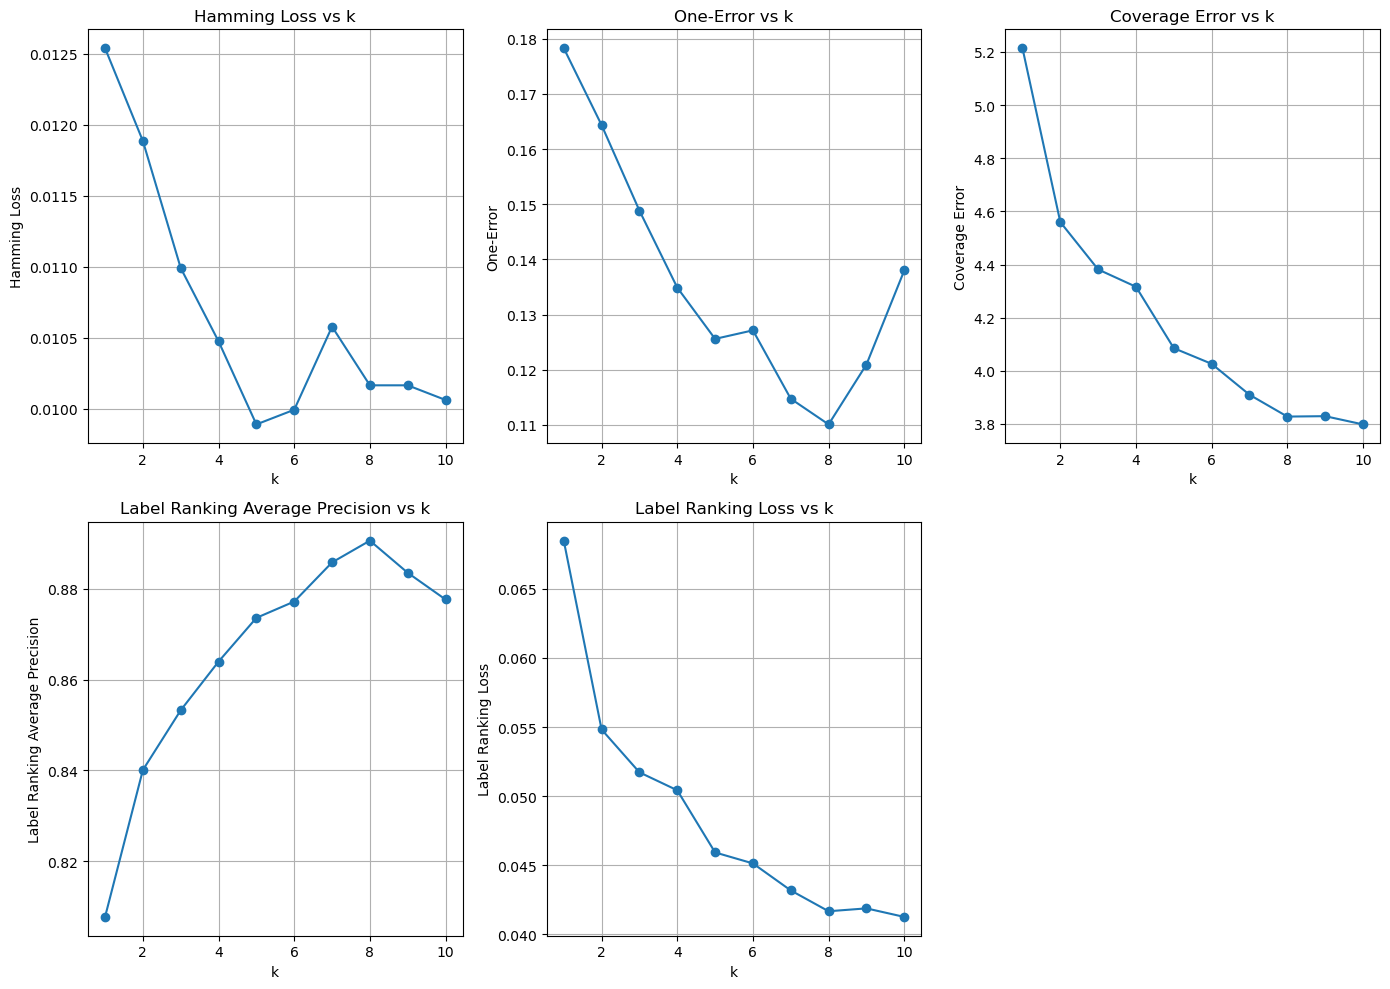

In [58]:
# Plot the metrics
%matplotlib inline
plt.figure(figsize=(14, 10))

plt.subplot(2, 3, 1)
plt.plot(k_values, hamming_losses, marker='o')
plt.title('Hamming Loss vs k')
plt.xlabel('k')
plt.ylabel('Hamming Loss')
plt.grid(True)

plt.subplot(2, 3, 2)
plt.plot(k_values, one_errors, marker='o')
plt.title('One-Error vs k')
plt.xlabel('k')
plt.ylabel('One-Error')
plt.grid(True)

plt.subplot(2, 3, 3)
plt.plot(k_values, coverage_errors, marker='o')
plt.title('Coverage Error vs k')
plt.xlabel('k')
plt.ylabel('Coverage Error')
plt.grid(True)

plt.subplot(2, 3, 4)
plt.plot(k_values, label_ranking_average_precisions, marker='o')
plt.title('Label Ranking Average Precision vs k')
plt.xlabel('k')
plt.ylabel('Label Ranking Average Precision')
plt.grid(True)

plt.subplot(2, 3, 5)
plt.plot(k_values, label_ranking_losses, marker='o')
plt.title('Label Ranking Loss vs k')
plt.xlabel('k')
plt.ylabel('Label Ranking Loss')
plt.grid(True)

plt.tight_layout()
plt.show()
